# Will it Rain?

Data sourced from : https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## Binary classification implemented with logistic regression which uses meteorological data to predict wheather it will rain.

### How it works:

- Input: set or subset of measurements of meteorological features (listed below) together with meteorological data set. 
- Output: 'it will rain' or 'it will not rain' with the accuracy of the classification for both training and test sets and the confusion matrix for the run. 
- Optional input: change the gradient descent run parameters. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt  
import seaborn as sns
from scipy.integrate import trapz

### Importing data and converting 'yes' it will rain to 1 and 'no' it will not rain to 0

In [2]:
data = pd.read_csv('weatherAUS.csv')
data.loc[data.RainTomorrow == 'No', 'RainTomorrow'] = 0
data.loc[data.RainTomorrow == 'Yes', 'RainTomorrow'] = 1
data.loc[data.RainToday == 'No', 'RainToday'] = 0
data.loc[data.RainToday == 'Yes', 'RainToday'] = 1

In [3]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,1.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0.2,0


### How many null (nan) values for each feature?

In [4]:
data.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

## Prelinary Analysis: Determining Importance of Each Feature

#### Since some features have many missing data points it will be helpful to determine the predictive power of each feature to see which ones are most relevant. 

### Drop all non numerical data and the predictions

In [5]:
numdataX = data.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am','WindDir3pm', 'RISK_MM','RainToday','RainTomorrow'], axis=1)
numdataX_shape = numdataX.shape
n_numX = numdataX_shape[1]

### Calculate the integral of the ROC curve of the rain vs no rain data for each feature. The larger the area the more predictive the feature will be.  

In [6]:
mtot = data.shape[0]               # max number of data points

raintomorrow = data.RainTomorrow   # our predictions


def rain_norain_ROC(feature, key, show_plot = True):
    feat_arr = np.asarray(feature)
    feat_arr = feat_arr[np.logical_not(np.isnan(feat_arr))]    # cleans feature data of NaN
    rain = np.asarray([feature[raintomorrow==1]])              # picks out feature data which corresponds to a RainTomorrow =1 
    notrain = np.asarray([feature[raintomorrow==0]])           # picks out feature data which corresponds to a RainTomorrow =0

    rain = rain[np.logical_not(np.isnan(rain))]                # cleans feature-rain data of NaN
    notrain = notrain[np.logical_not(np.isnan(notrain))]       # cleans feature-notrain data of NaN
   
    x = np.linspace(feat_arr.min(), feat_arr.max(), 100)

    y_rain, x_rain = np.histogram(rain , bins= x)              # histogram of feature data that corresponds to rain
    y_rain = y_rain/np.sum(y_rain)                             # normalization 
    y_notrain, x_notrain = np.histogram(notrain , bins= x)     # histogram of feature data that corresponds to no rain
    y_notrain = y_notrain/np.sum(y_notrain)                    # normalization 
   
    
    rain_sum = np.cumsum(y_rain)                               # cumulative sum of rain and not rain feature data
    notrain_sum = np.cumsum(y_notrain)
  

    s = 1-rain_sum                                              # True Positive (predict rain, it rains)
    b = 1-notrain_sum                                           # False Positive(predict rain, it does not rain)
    
    area = -trapz(s, b)
   
    
    if area < 0.5:                                             # ordering  to make sure the area under curve is > 0.5
        s = rain_sum
        b = notrain_sum
        area = trapz(s, b)
    
    
    if show_plot == True:                         # histogram plot of feature data divided into rain vs no rain 
        title1 = str(key) + " Data Rain vs No Rain"
        plt.title(title1)
        plt.step(x_rain[1:], y_rain, label='Rain')
        plt.step(x_notrain[1:], y_notrain, label='No Rain')
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()
    
        title2 = str(key)+ " Data Rain vs. No Rain Cumulative Sum"
        plt.title(title2)
        plt.plot(s, label='Rain')                 # plot of feature data cumulative sum divided into rain vs no rain
        plt.plot(b, label='No Rain')
        plt.legend()
        plt.show()
    
        title3 =  str(key)+ " Data Rain vs. No Rain ROC curve"
        plt.title(title3)         # plot of ROC curve 
        plt.plot(b, s, '.')
        plt.ylabel('rain')
        plt.xlabel('no rain')
        plt.show()
    return 'ROC area:', area, key



### Examples of Historgram and ROC curves for 2 features

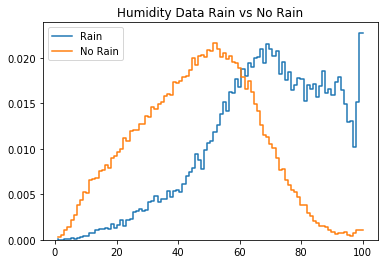

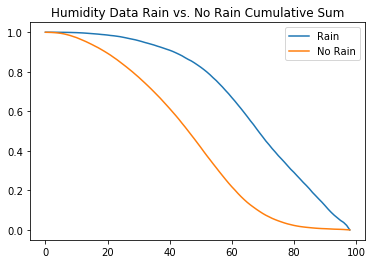

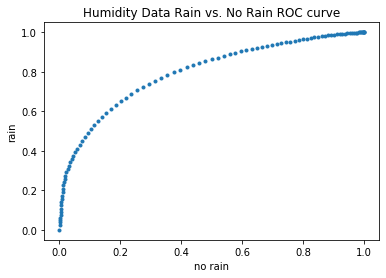

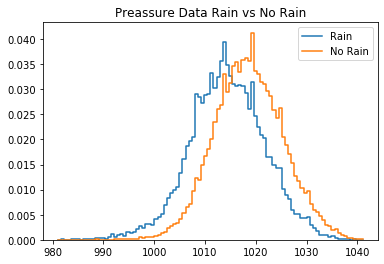

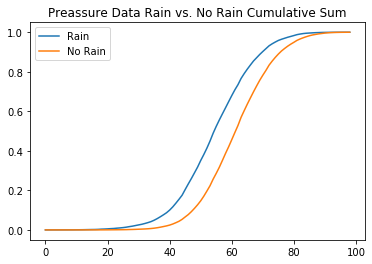

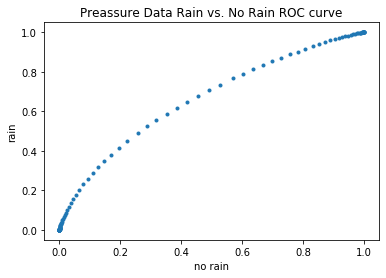

('ROC area:', 0.6629917874773262, 'Preassure')

In [7]:
rain_norain_ROC(numdataX.Humidity3pm, 'Humidity')
rain_norain_ROC(numdataX.Pressure9am, 'Preassure')

### Predictive power vs number of null entries
#### Calculated the ROC area for each feauture and list it next to number of null entries in total data set. By looking at this the featues with highest predictive power can be chosen. 

In [8]:
def allROC(dataset):
    pred= pd.DataFrame()
    for k,v in dataset.iteritems():
        ROC = rain_norain_ROC(v, k, False)
        numofnan = v.isna().sum()
        df = pd.DataFrame({'Power': ROC[1], 'NaN': numofnan}, index= {k})
        pred =pred.append(df)
    return pred

Power_vs_NaN = allROC(numdataX)
Power_vs_NaN.sort_values(by=['Power'])      # sorted by lowest to highest predictive power 

,Power,NaN
Rainfall,0.067285,1406
WindSpeed9am,0.442151,1348
Temp9am,0.520950,904
WindSpeed3pm,0.545959,2630
MinTemp,0.552951,637
Evaporation,0.586406,60843
Cloud9am,0.596760,53657
MaxTemp,0.609858,322
Temp3pm,0.633790,2726
WindGustSpeed,0.647329,9270


## Data Set Cleaning 

### Only keeping numerical data 

In [9]:
numdata = data.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am','WindDir3pm', 'RISK_MM', 'RainToday'], axis=1)

### Eliminate data rows with NaN values, keeping all feautes

In [10]:
cleanall = numdata.notna()
datacleanall = (numdata.loc[cleanall.prod(axis=1)==1])
datacleanall.shape

(58090, 17)

In [11]:
datacleanall

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
5939,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0
5940,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0
5942,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0
5943,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0
5944,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139108,19.3,33.4,0.0,6.0,11.0,35.0,9.0,20.0,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0
139109,21.2,32.6,0.0,7.6,8.6,37.0,13.0,11.0,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0
139110,20.7,32.8,0.0,5.6,11.0,33.0,17.0,11.0,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0
139111,19.5,31.8,0.0,6.2,10.6,26.0,9.0,17.0,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0


## Define training and test set
### (first implementaiton will be with all features) 


### Sizes of training and test sets for full and reduced data sets

In [12]:
data_nums = datacleanall.to_numpy()
m = data_nums.shape[0]     # number of data points
n = data_nums.shape[1]-1     # number of features
m_train = int(0.8 * m)
m_test = int(m- m_train)
data_nums = data_nums.astype(float)
n

16

In [13]:
def data_and_dimensions(data):
    datause = data
    data_nums_red = datause.to_numpy()
    m_red = data_nums_red.shape[0]     # number of data points
    n_red = data_nums_red.shape[1]-1   # number of features
    m_train_red = int(0.8 * m_red)     # number of data points in training set
    m_test_red = int(m_red- m_train_red) # number of data points in test set
    data_nums_red = data_nums_red.astype(float)
     
    dimensions = {'m': m_red,'n': n_red, 'm_train': m_train_red, 'm_test': m_test_red}
    return data_nums_red, dimensions

### Randomize order of rows to eliminated possible bias due to ordered date of measuremnt when diving data into training and test sets.

In [14]:
data_nums_shuff = data_nums
np.random.shuffle(data_nums_shuff)

### Define training set

In [15]:
X_train = data_nums_shuff[0:m_train , 0:n]
Y_train = data_nums_shuff[0:m_train,-1].reshape((m_train,1))
X_train.shape, Y_train.shape

((46472, 16), (46472, 1))

### Define test set

In [16]:
X_test = data_nums_shuff[0:m_test , 0:n]
Y_test = data_nums_shuff[0:m_test,-1].reshape((m_test,1))
X_test.shape, Y_test.shape

((11618, 16), (11618, 1))

### Rescaling features

In [17]:
def rescale(X_train, X_test, Y_train, Y_test, n, m_train, m_test): 
    mean_X_train = (np.sum(X_train, axis=0)/(m_train)).reshape((1,n))
    mean_X_test = (np.sum(X_test, axis=0)/(m_test)).reshape((1,n))

    max_train = np.amax(X_train, axis=0)
    min_train = np.amin(X_train, axis=0)

    max_test = np.amax(X_test, axis=0)
    min_test = np.amin(X_test, axis=0)

    maxmin_train = (max_train - min_train).reshape((1,n))
    maxmin_test = (max_test - min_test).reshape((1,n))

    X_trainR = (X_train - mean_X_train)/maxmin_train
    X_testR = (X_test - mean_X_test)/maxmin_test

    X_trainR = X_trainR.astype(float) 
    X_testR = X_testR.astype(float) 
    Y_train = Y_train.astype(float)
    Y_test = Y_test.astype(float)
    return X_trainR, X_testR, Y_train, Y_test

In [18]:
X_trainR, X_testR, Y_train, Y_test = rescale(X_train, X_test, Y_train, Y_test, n, m_train, m_test)

## Defining Functions for Logistic Regression and Gradient Descent 

### Sigmoid function

In [19]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s


### Initial parameter vector

In [20]:
def initial_theta(n):
    thetax = np.zeros((1,n))
    theta0=0
    return theta0, thetax


### Cost function

In [21]:
def cost(X, Y, theta0, thetax, m, lam):
    sig = sigmoid(theta0 + np.dot(X, thetax.T)).reshape((m,1))
    cost = - np.sum(Y*np.log(sig) + (1.0 - Y) * np.log(1.0- sig))/m
    reg = (lam/ (2.0 * m)) * np.sum(thetax[:]**2)
    return cost +reg

### Derivative of Cost function

In [22]:
def cost_grad(X, Y, theta0, thetax, m, lam):
    sig = sigmoid(theta0 + np.dot(X, thetax.T)).reshape((m,1))
    grad0 = np.sum((sig - Y), axis=0)/m
    gradx = np.dot(X.T, sig - Y)/m  + lam * thetax.T/m
    return grad0, gradx

### Prediction function which compares resulting prediction (will or will not rain) with actual outcome

In [23]:
def predict(theta0, thetax, X, m):   
    Y_prediction = np.ones((m,1)) 
    Y_predic_sig = np.ones((m,1)) 
    sig = sigmoid(theta0 + np.dot(X, thetax.T)).reshape((m,1))  
    for i in range(m):      
        Y_predic_sig[i,:] = sig[i,0]
        Y_prediction[i,:] = [1 if sig[i,0]> 0.5 else 0]
    assert(Y_prediction.shape == (m,1))
    return Y_prediction, Y_predic_sig


### Gradient Descent

In [24]:
def gradD(X, Y, m, n, lam, alpha, iterations):
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations, n+1))
    np.shape(theta_history[1,1:n+1])
    theta0, thetax = initial_theta(n)
    for it in range(iterations):
        theta0n = theta0 -  alpha * cost_grad(X, Y, theta0, thetax, m, lam)[0].T
        thetaxn = thetax -  alpha * cost_grad(X, Y, theta0, thetax, m, lam)[1].T
        theta_history[it,0]=theta0n
        theta_history[it,1:n+1]=thetaxn
        cost_history[it]= cost(X, Y,  theta0n, thetaxn, m, lam)
        theta0 = theta0n
        thetax = thetaxn
        #print(it,cost(X, Y,  theta0n, thetaxn, m, lam))
    theta = np.insert(thetax, 0, theta0)
    return theta, theta_history, cost_history 

## Running Gradient Descent 

### All features result

In [25]:
theta_result, theta_hist, cost_hist = gradD(X_trainR, Y_train, m_train, n, 0, 0.1, 6000)

<function matplotlib.pyplot.show(*args, **kw)>

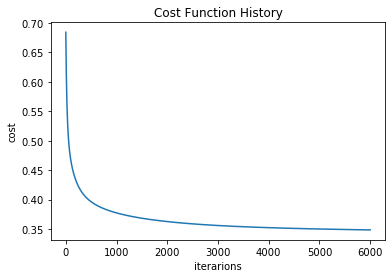

In [26]:
plt.title('Cost Function History')
plt.plot(cost_hist)
plt.xlabel('iterarions')
plt.ylabel('cost')
plt.show

## Accuracy of predition in persentage 

In [27]:
def accuracy(theta0r, thetaxr, X, Y, m):
    Y_predict = predict(theta0r, thetaxr, X, m)[0]
    acc = 100 - np.mean(np.abs(Y_predict - Y)) * 100
    return acc

### Accuracy of all feature training set preditions 

In [28]:
accuracy(theta_result[0], theta_result[1:], X_trainR, Y_train, m_train)

84.57565846100877

### Accuracy of all feature test set preditions 

In [29]:
accuracy(theta_result[0], theta_result[1:], X_testR, Y_test, m_test)

84.55844379411258

In [31]:
cost(X_testR, Y_test, theta_result[0], theta_result[1:], m_test, 1)

0.34742938263665973

In [32]:
cost(X_trainR, Y_train, theta_result[0], theta_result[1:], m_train, 1)

0.34877469034279457

## Confusion Matrix 

In [33]:
def confusion(theta0r, thetaxr, X, Y, m):
    Y_predict = predict(theta0r, thetaxr, X, m)[0]
    TP, TN, FP, FN = 0,0,0,0
    for i in range(0,m):
        if Y_predict[i]==1 and Y[i]==1: 
            TP += 1
        if  Y_predict[i]==0 and Y[i]==1: 
            TN += 1
        if Y_predict[i]==1 and Y[i]==0: 
            FP += 1
        if  Y_predict[i]==0 and Y[i]==0: 
            FN += 1
        sizes = [TP, TN, FP, FN]
    return sizes

#confusion(theta_result_red[0], theta_result_red[1:], X_trainR_red, Y_train_red, m_train_red)

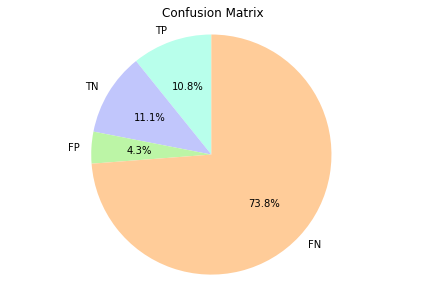

In [34]:
labels = ['TP', 'TN', 'FP', 'FN']
sizes = confusion(theta_result[0], theta_result[1:], X_trainR, Y_train, m_train)
    #colors
colors = ['#b8ffeb','#c1c6fc','#bcf5a6','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    #draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
ax1.axis('equal')  
plt.tight_layout()
plt.title('Confusion Matrix')
plt.show()

# Will it Rain?

## Predictor of Rain or Not Rain given set of meteorilogical measurements 

In [35]:
x = np.array([X_testR[450,:]]).reshape(1,n)   # example of set of measurements to enter

In [36]:
def will_it_rain(x, theta_result):
    sig = sigmoid(theta_result[0] + np.dot(x, theta_result[1:].T))
    if sig > 0.5:
        answer = 'it will rain'
    else:
        answer = 'it will not rain'
    return answer, 'sigmoid: ' + str(sig[0])
will_it_rain(x, theta_result)

('it will not rain', 'sigmoid: 0.05030790422054709')

# Total Model: Will it Rain? 

### How it works:

- Choose feature to use and input feature keys from list below into list: 'input_features'. This must also include 'RainTomorrow' key. 
- Input measurements of these featuers in the same order as the key names in 'input_features' into list: 'value_input'.
- Input full meteorological data set. 

Features Options: 

MinTemp           
MaxTemp            
Rainfall          
Evaporation      
Sunshine            
WindGustSpeed           
WindSpeed9am      
WindSpeed3pm      
Humidity9am       
Humidity3pm       
Pressure9am      
Pressure3pm      
Cloud9am         
Cloud3pm         
Temp9am            
Temp3pm      

### When it runs it will:

- Clean the selected feature columns of NaN values.
- Calculate number of data points, and size of test and training sets.
- Shuffle the data to eliminate original time ordering and divide into training and test sets.
- Rescale all features. 
- Run gradient descent to train logistic regression algorithm.
- Plot cost function history to ensure convergence.

### It will output:

- Accuracy of training and test set predictions.
- Confusion matrix with percentages of True Positive, True Negative, False Positive and False Negative preditions.
- Predition of 'it will rain' or 'it will not rain' for given input measurements in list 'value_input' (with sigmoid value, i.e. where along the sigmoid does this prediction fall). 

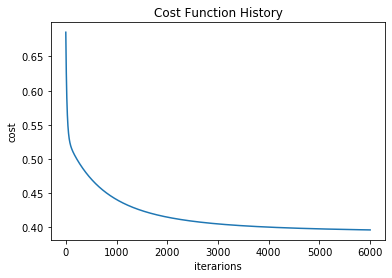

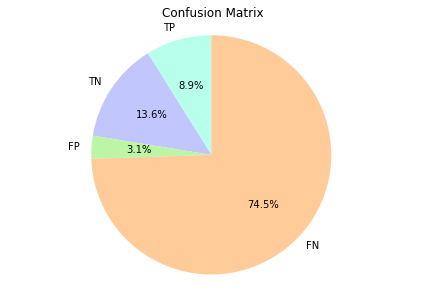

(('it will rain', 'sigmoid: 0.5277069664076528'),
 'Train Accuracy 83.3%, Test Accuracy 83.3%')

In [37]:
input_features = ['MaxTemp', 'MinTemp','Humidity3pm','Pressure9am','RainTomorrow']
value_input = np.array([ 0.0832136 ,  0.0088566 ,  0.22008363, -0.16806969])  # test example of values (rescaled) for inputed features 

def to_rain_or_not_to_rain(input_features, value_input, data, lam=0, alpha = 0.1, iterations = 6000):
    
    ## Define and clean data ## 
    
    data_include  = data[input_features]
    
    clean_include = data_include.notna()
    data_include_clean = (data_include.loc[clean_include.prod(axis=1)==1])    
    data_use = data_and_dimensions(data_include_clean)[0]
    
    ## Sizes of data sets and number of features ## 
    
    m = data_and_dimensions(data_include_clean)[1]['m']
    n = data_and_dimensions(data_include_clean)[1]['n']
    m_train = data_and_dimensions(data_include_clean)[1]['m_train']
    m_test = data_and_dimensions(data_include_clean)[1]['m_test']
    
    ## Shuffling data out of time order ## 
    
    data_shuff = data_use
    np.random.shuffle(data_shuff)
    
    ## Defining training and test sets ## 
    
    X_train = data_shuff[0:m_train , 0:n]
    Y_train = data_shuff[0:m_train,-1].reshape((m_train,1))
  
    X_test = data_shuff[0:m_test , 0:n]
    Y_test = data_shuff[0:m_test,-1].reshape((m_test,1))

    
    ## Rescaling features ##
    
    X_trainR, X_testR, Y_train, Y_test = rescale(X_train, X_test, Y_train, Y_test, n, m_train, m_test)
    
    ##### Running Gradient Descent ########
    
    theta_result, theta_hist, cost_hist = gradD(X_trainR, Y_train, m_train, n, lam , alpha , iterations)
    
    ##### Cost Function History Plot ########
    
    plt.title('Cost Function History')
    plt.plot(cost_hist)
    plt.xlabel('iterarions')
    plt.ylabel('cost')
    plt.show()
    
    ##### Accuracy #####
    
    acc_train = accuracy(theta_result[0], theta_result[1:], X_trainR, Y_train, m_train)
    acc_test = accuracy(theta_result[0], theta_result[1:], X_testR, Y_test, m_test)
    
    
    ##### Confusion Matrix Plot ##########
    labels = ['TP', 'TN', 'FP', 'FN']
    sizes = confusion(theta_result[0], theta_result[1:], X_trainR, Y_train, m_train)
    #colors
    colors = ['#b8ffeb','#c1c6fc','#bcf5a6','#ffcc99']
 
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    #draw circle
    centre_circle = plt.Circle((0,0),0.80,fc='white')
    fig = plt.gcf()
    ax1.axis('equal')  
    plt.tight_layout()
    plt.title('Confusion Matrix')
    plt.show()
    
    value_input = value_input.reshape(1,n)
    willitrain = will_it_rain(value_input, theta_result)
    textstr = f'Train Accuracy {acc_train:0.1f}%, Test Accuracy {acc_test:0.1f}%'
    
    return willitrain, textstr

to_rain_or_not_to_rain(input_features, value_input, data)
    
    